# Deep Learning ListenBrainz Recommendation
Written by Dean Cochran

# Abstract
The objective of this notebook is to generate a working example of how it is possible to improve recommendation of songs to users by incorporating more contextual information of the listening session. These contextual pieces of information can include, the time features of the listen, the audio features from the song listened to, and the metadata from the song listened to.

## User Note:
The requirements of this notebook are listed in the requirements.txt file within the project directory. Additionally, the same dataset from the listenbrainz open source data dumps must be downloaded to compute the notebook. 

Warning: This is a 39 GB data file with a massive download time, and this file takes around 45min to run with my 2018 Monterey macOS

I recommend preparing your computer for optimal download speeds. I utilize the ListenBrainz full export in the directory: /listenbrainz/fullexport/listenbrainz-dump-789-20220315-040002-fulllistenbrainz-listens-dump-789-20220315-040002-full.tar

Once downloaded, unzip the file within the project directory and your all set to run the notebook

# Imports

In [60]:
!pip install tensorflow-recommenders

import os
import json
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow import keras  
from typing import Dict, Text

plt.style.use('seaborn-whitegrid')

import time
start_time = time.time()

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


# Data Aggreation

Utilizing the pre-made function in the project folder, we can aggregate and process our information in little to no time at all

In [61]:
# Set to false if you have the 'listenbrainz-listens-dump-fullexport.csv' in the project directory
PROCESS_LISTENBRAINZ_DUMP = True

In [62]:
# aggregate all the python info
if PROCESS_LISTENBRAINZ_DUMP:
    !python3 process_lb_dump.py

# read the listenbrainz csv we just made
df = pd.read_csv('listenbrainz-listens-dump-fullexport.csv').drop(columns=['Unnamed: 0'])

Process started
reading a file in root directory: ./listenbrainz-listens-dump-789-20220315-040002-full/listens/1970/1.listens
 aggregating line 1250800
reading a file in root directory: ./listenbrainz-listens-dump-789-20220315-040002-full/listens/2005/2.listens
 aggregating line 500900
reading a file in root directory: ./listenbrainz-listens-dump-789-20220315-040002-full/listens/2005/3.listens
 aggregating line 92700
reading a file in root directory: ./listenbrainz-listens-dump-789-20220315-040002-full/listens/2005/4.listens
 aggregating line 102300
reading a file in root directory: ./listenbrainz-listens-dump-789-20220315-040002-full/listens/2005/5.listens
 aggregating line 95500
reading a file in root directory: ./listenbrainz-listens-dump-789-20220315-040002-full/listens/2005/6.listens
 aggregating line 110300
reading a file in root directory: ./listenbrainz-listens-dump-789-20220315-040002-full/listens/2005/7.listens
 aggregating line 116400
reading a file in root directory: ./list

# Data Preparation

Our text features in the data are not the cleanest but they will get the job done! So we should make take the following precautions and preform the following actions:

- remove users that have under 10 listens
- make sure all user_ids are string
- make sure all timestamps are int
- make sure all recording_msids are string
- make sure all track_names are string
- make sure all artist_names are string


In [63]:
#clean the data with this chunck of code
removeUsers = [i for i,val in zip(df['user_id'].value_counts().index,df['user_id'].value_counts()) if val < 10]
df[df['user_id'].apply(lambda x: x not in removeUsers)]
df['user_id'] = df['user_id'].apply(lambda x: str(x))
df['timestamp'] = df['timestamp'].apply(lambda x: int(x))
df['track_name'] = df['track_name'].apply(lambda x: str(x))
df['artist_name'] = df['artist_name'].apply(lambda x: str(x))
df['recording_msid'] = df['recording_msid'].apply(lambda x: str(x))

## Observations from our dataframe

In [64]:
rows,cols = df.shape
print('# rows',rows)
print('# cols',cols)
print('avg # of listens per song: ',np.mean(df['recording_msid'].value_counts()))
print(df['artist_name'].value_counts()[:10])
df

# rows 2534176
# cols 5
avg # of listens per song:  4.88714638628917
The Beatles         21657
Radiohead           14986
Lil' Wayne          13786
Linkin Park         13401
System of a Down    11353
Green Day           10595
Pink Floyd          10024
Metallica            9680
Nine Inch Nails      8893
Depeche Mode         8835
Name: artist_name, dtype: int64


,user_id,timestamp,track_name,artist_name,recording_msid
0,15934,0,Calvi,Izia,63887ddb-d3b0-4f5f-b4ff-fb7caf072538
1,15934,0,Sous les pavés,Izia,365a4bc1-c8b5-4173-850b-394662642599
2,15934,0,Trop vite,Izia,b8cd1c25-b7c4-4f0b-b0fd-2d381ee0d583
3,15934,0,Sunset,Izia,c9a8fde1-0703-4ccd-9e69-245b9b323ae9
4,15934,0,Esseulés,Izia,8c279298-c4aa-4eb7-a6f6-1d538b8f11d6
...,...,...,...,...,...
2534171,11325,1128106599,I Know Why,Sheryl Crow,d7bf3eae-fc71-459b-8d31-3e25a8660bd0
2534172,12612,1128106599,The National Anthem,Radiohead,0267dfbc-f93e-4bbc-a063-b365b70443ce
2534173,14629,1128106605,Iron Man,Black Sabbath,ed49724a-7660-4822-856c-408f82ab17ec
2534174,12900,1128106608,The Irony of It All,The Streets,0343337f-54dd-40b5-83a6-7be14e22d411


In [65]:
# who listens to Lil' Wayne the most
df[df['artist_name']=="Lil' Wayne"]['user_id'].value_counts()[:1]

13277    13526
Name: user_id, dtype: int64

In [66]:
# who listens to The Beatles the most
df[df['artist_name']=="The Beatles"]['user_id'].value_counts()[:1]

14512    4098
Name: user_id, dtype: int64

In [67]:
# who listens to Radiohead the most
df[df['artist_name']=="Radiohead"]['user_id'].value_counts()[:1]

15748    2155
Name: user_id, dtype: int64

# Setting up our tensor datasets

we need two datasets:

- one to represent every listen
- one to represent every unique recording

In [68]:
# using tensorflow to create TF datsets of the listening behaviour and list of unique recordings
dataset = tf.data.Dataset.from_tensor_slices(dict(df))
listens = dataset.map(lambda x: {
    "recording_msid":x['recording_msid'],
    "user_id": x['user_id'],
    "timestamp": x['timestamp'],
    "artist_name": x['artist_name'],
})

recordingdataset = tf.data.Dataset.from_tensor_slices(dict(df.groupby('recording_msid')['artist_name','track_name'].first().reset_index()))
recording_msids = recordingdataset.map(lambda x: {
    "recording_msid":x['recording_msid'],
    "artist_name": x['artist_name'],
})

/var/folders/42/c20b9csx1tv016cm04x9syc40000gn/T/ipykernel_58739/823632245.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  recordingdataset = tf.data.Dataset.from_tensor_slices(dict(df.groupby('recording_msid')['artist_name','track_name'].first().reset_index()))


## Creating unique lists of users, recordings, and our other features 
This is necessary to create a vocabulary for the user_ids, recording_msids, artist_names, and timestamp

In [69]:
unique_recording_msids = np.unique(np.concatenate(list(recording_msids.batch(1000).map(lambda x: x["recording_msid"]))))
unique_recording_msids[:10]

array([b'00002d3e-542a-4dca-9ae8-e25e9c0a3781',
       b'000034a9-b580-4bf3-b8db-4ccfab32d1a7',
       b'00008997-e554-44b3-bcf4-77dccf8f0c0d',
       b'00009800-a061-47ae-b5f0-e35eeea7ecee',
       b'0000a061-36cf-4e3e-b42b-efab7c4b6846',
       b'0000b64d-522e-4e1b-a94b-7a756e4948f6',
       b'0000d0ee-a1cc-4983-8a15-d7c0bcf6578b',
       b'0000de43-70af-4ad2-bd43-d8250e23e91c',
       b'0000e153-ba17-41a3-90b7-0d8d57347530',
       b'0000e793-64d7-4aab-aa63-b3fa41adbddd'], dtype=object)

In [70]:
unique_user_ids = np.unique(np.concatenate(list(listens.batch(1000).map(lambda x: x["user_id"]))))
unique_user_ids[:10]

array([b'10005', b'10006', b'10012', b'10315', b'1039', b'1049', b'10610',
       b'10635', b'10787', b'11'], dtype=object)

In [71]:
unique_artist_names = np.unique(np.concatenate(list(recording_msids.batch(1000).map(lambda x: x["artist_name"]))))
unique_artist_names[:10]

array([b'!!!', b'!((0rkza1', b'!Action Pact!', b'!distain', b'"Demons"',
       b'"Dusty Rhodes" Rowe', b'"Weird Al" Yankovic',
       b'"the band (aint got a name yet)"', b'#18',
       b'$ bboy muzak (jason levis'], dtype=object)

In [72]:
timestamps = np.concatenate(list(listens.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)
timestamp_buckets[:10]

array([       0.        ,  1129235.87087087,  2258471.74174174,
        3387707.61261261,  4516943.48348348,  5646179.35435435,
        6775415.22522523,  7904651.0960961 ,  9033886.96696697,
       10163122.83783784])

# Building User and Recording Model

In [73]:
class RecordingModel(tf.keras.Model):
  """
  This class represents a single recording
  The functionality of the model creates an embedding that can describe a recording when passed a dicitonary of a recording_msid and the artist_name
  """
  def __init__(self):
    super().__init__()

    max_tokens = 10_000
    
    ## MSID embeddings
    self.msid_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(vocabulary=unique_recording_msids,mask_token=None),
      tf.keras.layers.Embedding(len(unique_recording_msids) + 1, 32)
    ])

    ## artist names embeddings
    self.artist_name_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(vocabulary=unique_artist_names,mask_token=None),
      tf.keras.layers.Embedding(len(unique_artist_names) + 1, 32)
    ])

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.msid_embedding(inputs['recording_msid']),
        self.artist_name_embedding(inputs['artist_name'])
    ], axis=1)

In [83]:
class UserModel(tf.keras.Model):
  """
  This class represents a single user
  The functionality of the model creates an embedding that can describe a user when passed a dicitonary of a user_id and the timestamp of a listen
  """
  def __init__(self):
    super().__init__()

    ## user id embeddings
    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])
    ## timestamp embeddings
    self.timestamp_embedding = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
    ])
    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )
    self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

# Building Query and Candidate model

In [84]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # User model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [85]:
class CandidateModel(tf.keras.Model):
  """Model for encoding recordings."""

  def __init__(self, layer_sizes):
    """Model for encoding recordings.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # Recording model for generating embeddings.
    self.embedding_model = RecordingModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()
   
    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

# Building ListenBrainz Recommendation Model

With both QueryModel and CandidateModel defined, I can put together a combined model and implement our loss and metrics logic. To make things simple, I'll enforce that the model structure is the same across the query and candidate models.


Since the expressive power of deep linear models is no greater than that of shallow linear models, we use ReLU activations for all but the last hidden layer. The final hidden layer does not use any activation function: using an activation function would limit the output space of the final embeddings and might negatively impact the performance of the model. For instance, if ReLUs are used in the projection layer, all components in the output embedding would be non-negative.

In [86]:
class ListenBrainzModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics = tfrs.metrics.FactorizedTopK(candidates=recording_msids.batch(128).map(self.candidate_model)),
    )

  def compute_loss(self, features, training=False):
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"]
    })
    recording_embeddings = self.candidate_model({
        "recording_msid": features["recording_msid"],
        "artist_name": features["artist_name"]
    })

    return self.task(
        query_embeddings, recording_embeddings, compute_metrics=not training)

# Split data

Here we split our data in an 80/20 split and cache the data to fit within our tensorflow recommendation model

In [87]:
tf.random.set_seed(42)
shuffled = listens.shuffle(40_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(40_000)
test = shuffled.skip(40_000).take(10_000)

cached_train = train.shuffle(40_000).batch(2048)
cached_test = test.batch(4096).cache()

# Fit/Eval with different layers 

Defining deeper models will require us to stack mode layers on top of this first input. A progressively narrower stack of layers, separated by an activation function, is a common pattern:

                            +----------------------+
                            |      128 x 64        |
                            +----------------------+
                                       | relu
                          +--------------------------+
                          |        256 x 128         |
                          +--------------------------+
                                       | relu
                        +------------------------------+
                        |          ... x 256           |
                        +------------------------------+

In [88]:
num_epochs = 30
# specifying how many times we will run our model metrics for the visualizations (i.e. val_freq = 20 means we have 20 points for each model to plot)
val_freq = 5

In [89]:
# SINGLE LAYER MODEL
print('SINGLE LAYER MODEL')
model = ListenBrainzModel([32])
print('compiling')
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
print('fitting')
one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=val_freq,
    epochs=num_epochs,
    verbose=0)

# TWO LAYER MODEL
print('TWO LAYER MODEL')
model = ListenBrainzModel([64, 32])
print('compiling')
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
print('fitting')
two_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=val_freq,
    epochs=num_epochs,
    verbose=0)

# THREE LAYER MODEL
print('THREE LAYER MODEL')
model = ListenBrainzModel([128, 64, 32])
print('compiling')
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
print('fitting')
three_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=val_freq,
    epochs=num_epochs,
    verbose=0)




SINGLE LAYER MODEL
compiling
fitting
TWO LAYER MODEL
compiling
fitting
THREE LAYER MODEL
compiling
fitting


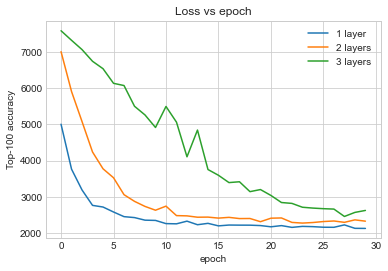

In [90]:
# Computing Accuracy Visualization
epochs = range(num_epochs)

#plot every models results
plt.plot(epochs, one_layer_history.history["loss"], label="1 layer")
plt.plot(epochs, two_layer_history.history["loss"], label="2 layers")
plt.plot(epochs, three_layer_history.history["loss"], label="3 layers")
plt.title("Loss vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

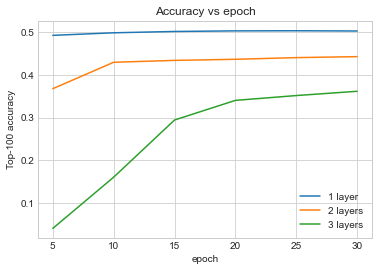

In [91]:
# Computing Accuracy Visualization
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* val_freq for x in range(num_validation_runs)]

#plot every models results
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

# Using best model to serve predictions

Since the single layer seemed to preform more optimally, we can take the computed model and utilize it to generate recommendations without any ranking 

In [92]:
# Re-Initializng Best Model, change layers in ListenBrainzModel if you want to see the predictions of a different model
num_epochs = 30

# # # # # # # # # # # # # # 
model = ListenBrainzModel([32])
# # # # # # # # # # # # # #

print('compiling')
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
print('fitting')
one_layer_history = model.fit(
    cached_train,
    epochs=num_epochs,
    verbose=0)
print('evaluating')
model.evaluate(cached_test, return_dict=True)

In [ ]:
# Create a model that takes in raw query features and recommends recordings out of the entire recordings dataset.
# Replace key name with what kind of predicitons you would like to recieve
# ex.recording_msids.batch(100).map(lambda x: (x['recording_msid'], model.candidate_model(x))) # give's recording_msid recommendations
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
index.index_from_dataset(
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    recording_msids.batch(100).map(lambda x: (x['artist_name'], model.candidate_model(x))) 
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
)

In [ ]:
def get_query(df, user_id, row_num):
    """
    Description:
    Given an instance in our data, we can give recommendations for a user at a particular timestamp

    params:
    df - pd.DataFrame
    user_id - Integer corresponding to a user id in the data frame
    row_num - Integer corresponding to which instance of the users listens you would like to use (UN-TESTED, most likely un-important and gives identical results)

    """
    return df[df['user_id'] == f'{user_id}'].iloc[row_num][0:2].map(lambda x: tf.expand_dims(x, axis=0))

In [ ]:
# Get recommendations.
query = get_query(df,13277,15)
_, artists = index(query)
print('LILWAYNE FAN BOY: User 13277 listens to:')
print(# what other artists does he listen to
df[df['user_id']=='13277']['artist_name'].value_counts()[:5])
print()
print(f"Artist name of each recording id for user 13277:")
print(artists.numpy())

LILWAYNE FAN BOY: User 13277 listens to:
Lil' Wayne     13526
Drake           5749
Bright Eyes     3325
Kanye West      3055
The Format      2698
Name: artist_name, dtype: int64

Artist name of each recording id for user 13277:
[[b'James Binney' b"Juelz Santana feat. Young Jeezy & Lil' Wayne"
  b'Drake' b'James Binney' b'Weezer' b"Lil' Wayne" b"Lil' Wayne"
  b"Lil' Wayne" b'Peter Frampton' b'Bright Eyes']]


In [ ]:
# Get recommendations.
query = get_query(df,14512,15)
_, artists = index(query)
print('THE BEATLES FAN BOY: User 14512 listens to:')
print(# what other artists does he listen to
df[df['user_id']=='14512']['artist_name'].value_counts()[:5])
print()
print(f"Artist name of each recording idfor user 14512:")
print(artists.numpy())

THE BEATLES FAN BOY: User 14512 listens to:
The Beatles      4098
Led Zeppelin     1078
Queen             963
Guns N' Roses     836
Graham Nash       791
Name: artist_name, dtype: int64

Artist name of each recording idfor user 14512:
[[b'Megadeth' b'The Rolling Stones' b'Skid Row' b'The Who' b'The Who'
  b'The Who' b'The Who' b'The Who' b'Rush' b'Van Halen']]


In [ ]:
# Get recommendations.
query = get_query(df,15748,15)
_, artists = index(query)
print('RADIOHEAD FAN BOY: User 15748 listens to:')
print(# what other artists does he listen to
df[df['user_id']=='15748']['artist_name'].value_counts()[:5])
print(f"Artist name of each recording idfor user 15748:")
print(artists.numpy())

RADIOHEAD FAN BOY: User 15748 listens to:
Nine Inch Nails          2995
Radiohead                2155
The Beatles              1496
The Smashing Pumpkins     861
Coldplay                  649
Name: artist_name, dtype: int64
Artist name of each recording idfor user 15748:
[[b'Blue October' b'The Smashing Pumpkins' b'Weezer' b'A Perfect Circle'
  b'Gwen Stefani' b'Queens of the Stone Age' b'Feist' b'Radiohead'
  b'Radiohead' b'Radiohead']]


In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 1987.0479259490967 seconds ---


# End of Notebook